In [1]:
from ultranest import ReactiveNestedSampler

In [2]:
import numpy as np
from numpy import sin, pi

def sine_model(t, B, A, P, t0):
    return A * sin((t / P + t0) * 2 * pi) + B



In [3]:
np.random.seed(42)

n_data = 20

# time of observations
t = np.random.uniform(0, 5, size=n_data)

# measurement values
yerr = 1.0
y = np.random.normal(sine_model(t, A=4.2, P=3, t0=0, B=1.0), yerr)

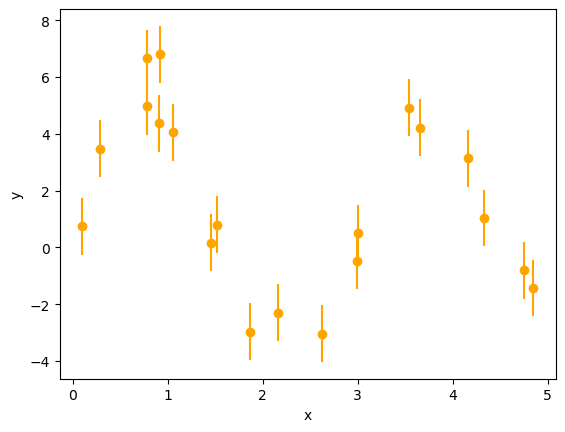

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange');

In [5]:
parameters = ['B', 'A', 'P', '$t_0$']

def prior_transform(cube):
    # the argument, cube, consists of values from 0 to 1
    # we have to convert them to physical scales

    params = cube.copy()
    # let background level go from -10 to +10
    params[0] = cube[0] * 20 - 10
    # let amplitude go from 0.01 to 100
    params[1] = 10**(cube[1] * 4 - 2)
    # let period go from 0.3 to 30
    params[2] = 10**(cube[2] * 2)
    # let time go from 0 to 1
    params[3] = cube[3]
    return params

In [6]:
import scipy.stats

def log_likelihood(params):
    # unpack the current parameters:
    B, A, P, t0 = params

    # compute for each x point, where it should lie in y
    y_model = sine_model(t, A=A, B=B, P=P, t0=t0)
    # compute likelihood
    loglike = -0.5 * (((y_model - y) / yerr)**2).sum()

    return loglike

In [7]:
sampler = ReactiveNestedSampler(parameters, log_likelihood, prior_transform,
    wrapped_params=[False, False, False, True],
)

In [8]:
result = sampler.run(min_num_live_points=400, dKL=np.inf, min_ess=100)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-8  61 [-7.7535..-7.7531]*| it/evals=7920/51796 eff=15.4098% N=400 00 0  0 
[ultranest] Likelihood function evaluations: 51810
[ultranest]   logZ = -22.9 +- 0.1181
[ultranest] Effective samples strategy satisfied (ESS = 2138.5, need >100)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <inf nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.


In [9]:
sampler.print_results()


logZ = -22.918 +- 0.291
  single instance: logZ = -22.918 +- 0.182
  bootstrapped   : logZ = -22.898 +- 0.291
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    B                   : -0.45 │ ▁ ▁▁▁▁▁▁▁▁▂▂▃▄▅▅▆▇▇▇▆▆▅▄▃▂▁▁▁▁▁▁▁▁▁ ▁ │1.81      0.67 +- 0.25
    A                   : 2.94  │ ▁▁▁▁▁▁▁▁▁▂▂▃▃▄▅▅▆▇▇▆▇▅▅▄▃▂▂▂▁▁▁▁▁▁▁ ▁ │5.80      4.37 +- 0.35
    P                   : 2.719 │ ▁▁▁▁▁▁▁▁▁▁▂▃▄▄▆▅▇▇▇▆▇▇▆▅▄▃▃▂▁▁▁▁▁▁▁ ▁ │3.268     2.998 +- 0.070
    $t_0$               : 0.00  │▅▁▁                                ▁▁▃▇│1.00      0.64 +- 0.46



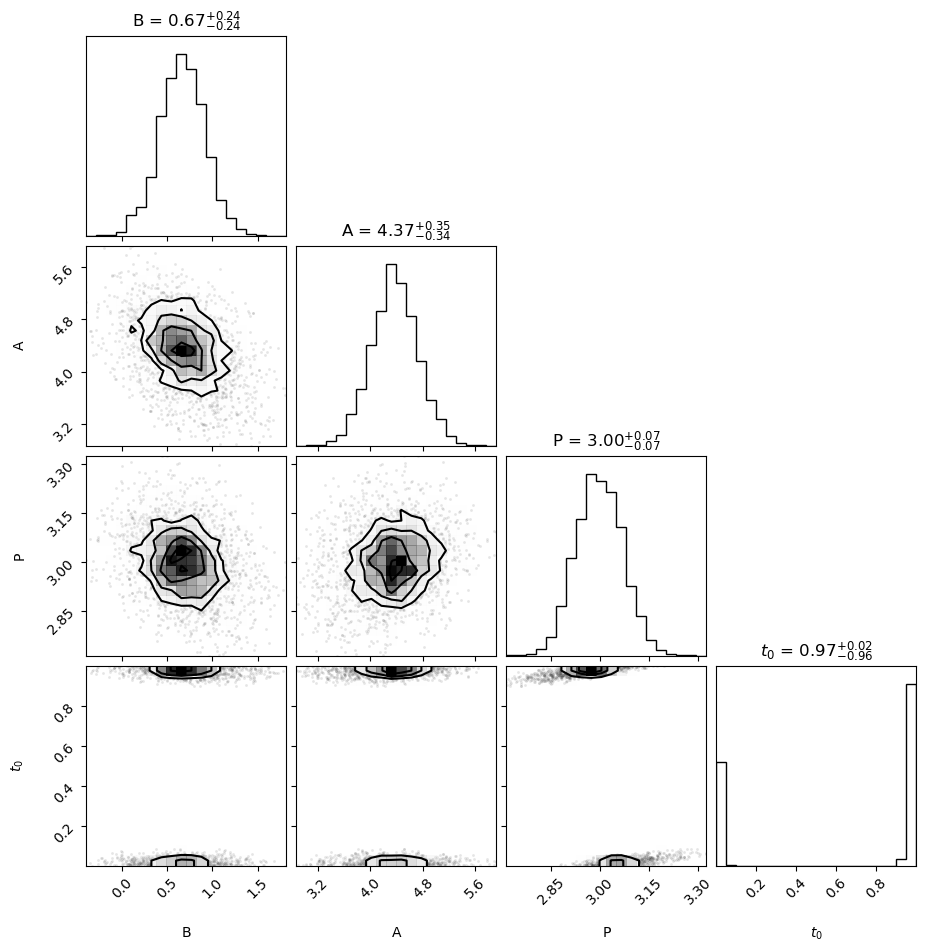

In [10]:
from ultranest.plot import cornerplot
cornerplot(result)

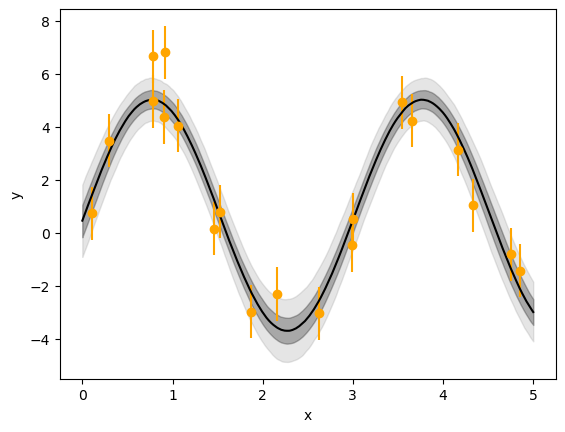

In [11]:
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x=t, y=y, yerr=yerr,
             marker='o', ls=' ', color='orange')


t_grid = np.linspace(0, 5, 400)

from ultranest.plot import PredictionBand
band = PredictionBand(t_grid)

# go through the solutions
for B, A, P, t0 in sampler.results['samples']:
    # compute for each time the y value
    band.add(sine_model(t_grid, A=A, B=B, P=P, t0=t0))

band.line(color='k')
# add 1 sigma quantile
band.shade(color='k', alpha=0.3)
# add wider quantile (0.01 .. 0.99)
band.shade(q=0.49, color='gray', alpha=0.2)

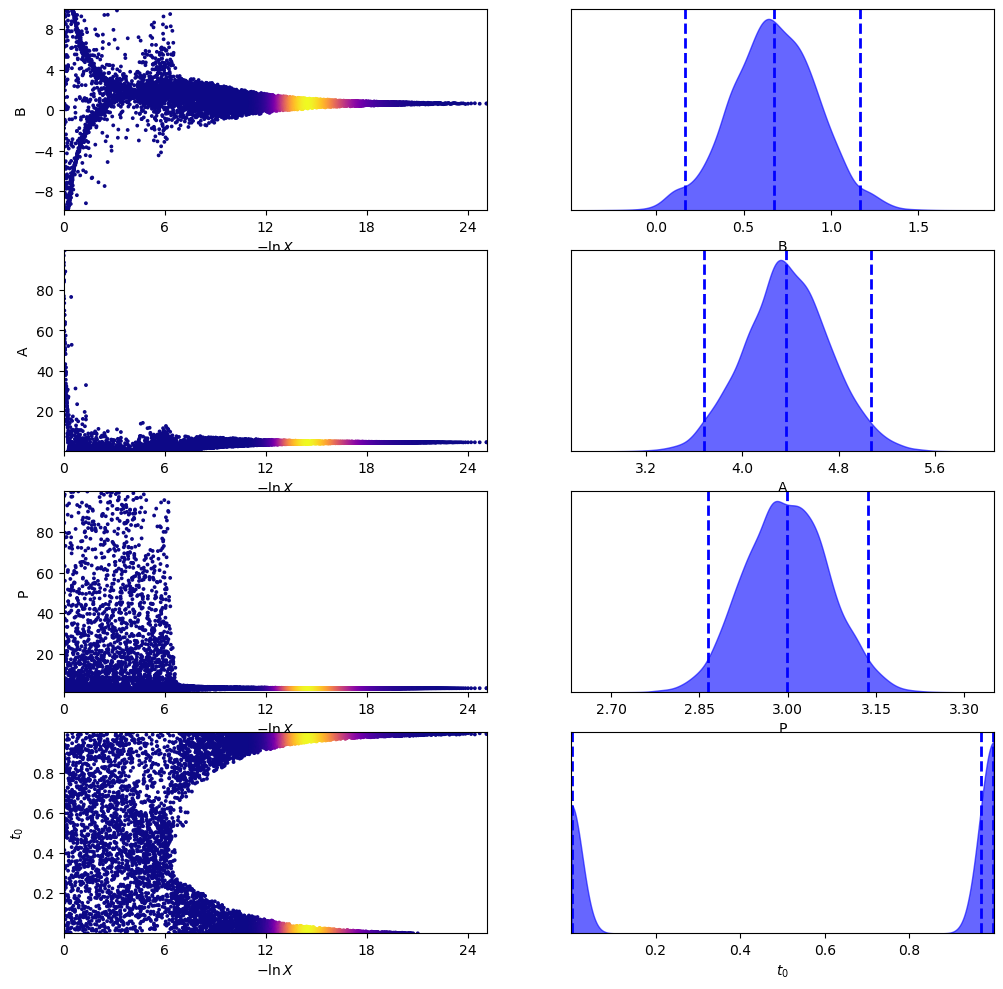

In [12]:
sampler.plot_trace()